In [1]:
import sys
import pandas as pd
import pickle
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import joblib
import glob
import os

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler

from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier

print(sys.version)

3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]


In [2]:
# train original data
# curr_dir = os.path.dirname(os.path.realpath(__file__))
# df_train = pd.read_csv(os.path.join(curr_dir, 'backup_orignal_data', 'dataset_train_NASDAQ100.csv'))
# df_test = pd.read_csv(os.path.join(curr_dir, 'backup_orignal_data', 'dataset_test_sp500.csv'))
# df_train

In [3]:
# train with the latest data
__file__ = 'build_ML_model.ipynb'
curr_dir = os.path.dirname(os.path.realpath(__file__))
list_of_training_set_files = glob.glob(os.path.join(curr_dir, 'dataset', 'NASDAQ100-Symbols[0-9]*.csv'))
latest_data_train_file = max(list_of_training_set_files, key=os.path.getctime)
print(f'TRAINING SET FILE: {latest_data_train_file}')

list_of_test_set_files = glob.glob(os.path.join(curr_dir, 'dataset', 'S&P500-Symbols[0-9]*.csv'))
latest_data_test_file = max(list_of_test_set_files, key=os.path.getctime)
print(f'TEST SET FILE: {latest_data_test_file}')

df_train = pd.read_csv(latest_data_train_file)
df_test = pd.read_csv(latest_data_test_file)

df_train

TRAINING SET FILE: /home/thomas/Desktop/capstone_project/backend/stocks/webscraper/dataset/NASDAQ100-Symbols21_03_16-071440.csv
TEST SET FILE: /home/thomas/Desktop/capstone_project/backend/stocks/webscraper/dataset/S&P500-Symbols21_03_16-071421.csv


,Symbol,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio,target
0,ATVI,92.87,50.51,104.53,3136628.0,5846123.0,7.172300e+10,32.83,2.82,NaN
1,ADBE,444.40,255.13,536.88,2508699.0,2632633.0,2.145420e+11,41.33,10.83,NaN
2,AMD,81.91,36.75,99.23,38855543.0,43073091.0,9.993400e+10,39.97,2.06,NaN
3,ALXN,151.59,75.57,162.60,2367278.0,3017306.0,3.345600e+10,55.95,2.72,NaN
4,ALGN,551.09,127.88,634.46,733629.0,585757.0,4.422300e+10,24.94,22.41,NaN
...,...,...,...,...,...,...,...,...,...,...
97,WBA,55.00,33.36,56.11,1164594.0,6544325.0,4.741000e+10,NaN,-0.80,NaN
98,WDAY,256.67,107.75,282.77,215756.0,2152575.0,6.310200e+10,NaN,-1.19,NaN
99,XEL,62.98,46.58,76.44,260382.0,2755185.0,3.397400e+10,22.65,2.79,NaN
100,XLNX,130.06,68.02,154.93,362837.0,2604940.0,3.233500e+10,52.63,2.50,NaN


In [4]:
df_test

,Symbol,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio,target
0,MMM,186.03,114.04,189.63,3232604.0,2691181.0,1.097280e+11,20.48,9.25,Overvalued
1,ABT,117.19,61.61,128.54,4044983.0,4985537.0,2.092180e+11,47.18,2.50,Undervalued
2,ABBV,108.67,62.55,113.41,6558661.0,7065142.0,1.947060e+11,40.54,2.72,Overvalued
3,ABMD,300.85,119.01,387.40,201326.0,345525.0,1.389400e+10,70.02,4.39,Undervalued
4,ACN,263.69,137.15,271.18,2291210.0,2044428.0,1.760340e+11,32.77,8.12,Overvalued
...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.00,54.95,110.66,170480.0,1769713.0,3.250500e+10,36.85,2.94,NaN
501,ZBRA,481.19,163.44,516.79,17314.0,382540.0,2.563900e+10,51.29,9.35,NaN
502,ZBH,161.00,74.37,170.05,83887.0,1273686.0,3.321600e+10,NaN,-0.67,NaN
503,ZION,57.17,23.58,59.37,122302.0,1452311.0,9.259000e+09,18.67,3.02,NaN


In [5]:
# perform preprocessing data before they can be used

# drop near fair value
df_train_drop_fair_value = df_train[df_train['target'] != 'Near Fair Value']
df_test_drop_fair_value = df_test[df_test['target'] != 'Near Fair Value']
# print(df_test_drop_na['target'])

# removing N/A
df_train_drop_na = df_train_drop_fair_value.dropna()
df_test_drop_na = df_test_drop_fair_value.dropna()

# remove intersection between two dataframes in test set
df_test_drop_na = pd.merge(df_test_drop_na, df_train_drop_na, how='outer', indicator=True).query('_merge=="left_only"').drop(['_merge'], axis=1)

# drop Symbol col
p_df_train = df_train_drop_na.drop(['Symbol', 'target'], axis=1)
p_df_test = df_test_drop_na.drop(['Symbol', 'target'], axis=1)

p_df_train

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
79,133.56,101.42,148.77,354241.0,5096722.0,1.835300e+11,25.98,5.12


In [6]:
p_df_test

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,186.03,114.04,189.63,3232604.0,2691181.0,1.097280e+11,20.48,9.25
1,117.19,61.61,128.54,4044983.0,4985537.0,2.092180e+11,47.18,2.50
2,108.67,62.55,113.41,6558661.0,7065142.0,1.947060e+11,40.54,2.72
3,300.85,119.01,387.40,201326.0,345525.0,1.389400e+10,70.02,4.39
4,263.69,137.15,271.18,2291210.0,2044428.0,1.760340e+11,32.77,8.12
...,...,...,...,...,...,...,...,...
254,33.03,20.48,43.00,1207113.0,1497701.0,1.654600e+10,63.43,0.53
255,55.81,48.84,61.95,1790718.0,20128091.0,2.304740e+11,12.95,4.30
256,73.64,35.07,84.32,969508.0,1219752.0,1.408800e+10,34.37,2.17
257,24.99,17.39,25.73,4522861.0,4518586.0,1.013500e+10,13.78,1.79


In [7]:
# standardize features
sdd_df_train = ((p_df_train) - p_df_train.mean()) / p_df_train.std()
sdd_df_test = ((p_df_test) - p_df_test.mean()) / p_df_test.std()
sdd_df_train


,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sdd_df_test

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,-0.067910,0.025866,-0.102103,-0.046988,-0.165753,0.111644,-0.218092,-0.061135
1,-0.230269,-0.230930,-0.234915,0.068494,0.100508,0.578860,0.011853,-0.065209
2,-0.250363,-0.226326,-0.267808,0.425821,0.341848,0.510710,-0.045332,-0.065077
3,0.202892,0.050209,0.327858,-0.477893,-0.437968,-0.338403,0.208555,-0.064069
4,0.115250,0.139057,0.075191,-0.180810,-0.240809,0.423024,-0.112248,-0.061817
...,...,...,...,...,...,...,...,...
254,-0.428760,-0.432380,-0.420882,-0.334917,-0.304257,-0.325949,0.151801,-0.066399
255,-0.375033,-0.293476,-0.379684,-0.251956,1.857812,0.678680,-0.282941,-0.064123
256,-0.332981,-0.360920,-0.331051,-0.368694,-0.336514,-0.337492,-0.098469,-0.065409
257,-0.447722,-0.447515,-0.458428,0.136426,0.046318,-0.356055,-0.275793,-0.065638


In [9]:
# dump scaler for later use in backend API
scaler = StandardScaler()
data_train_scaler = scaler.fit_transform(p_df_train)
data_test_scaler = scaler.fit_transform(p_df_test)

train_scaler_file_name = 'train_scaler.pkl'
joblib.dump(scaler, train_scaler_file_name)

['train_scaler.pkl']

In [10]:
# balance dataset after standardization
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(sdd_df_train, df_train_drop_na['target'])
X_test_ros, y_test_ros = ros.fit_resample(sdd_df_test, df_test_drop_na['target'])

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [57]:
print('df_train_drop_na: ', len(df_train_drop_na['target']))
print('df_test_drop_na: ', len(df_test_drop_na['target']))

df_train_drop_na:  78
df_test_drop_na:  271


In [58]:
print('X_train_ros: ', len(X_train_ros))
print('y_ros: ', len(y_test_ros))

X_train_ros:  118
y_ros:  398


In [59]:
# perform analysis on unbalanced dataset
print('Analysis on unbalanced dataset')
# find score for Gaussian Naive Bayes classifer
gnb = GaussianNB()
gnb.fit(sdd_df_train, df_train_drop_na['target'])
gnb_score = gnb.score(sdd_df_test, df_test_drop_na['target'])
print("GNB classifer score (accuracy) = ", gnb_score)

# find score for KNN classifer
knn = KNeighborsClassifier()
knn.fit(sdd_df_train, df_train_drop_na['target'])
knn_score = knn.score(sdd_df_test, df_test_drop_na['target'])
print("KNN classifer score (accuracy) = ", knn_score)

# find score for SVM classifier
svm = SVC()
svm.fit(sdd_df_train, df_train_drop_na['target'])
svm_score = svm.score(sdd_df_test, df_test_drop_na['target'])
print("SVM classifer score (accuracy) = ", svm_score)

Analysis on unbalanced dataset
GNB classifer score (accuracy) =  0.6715867158671587
KNN classifer score (accuracy) =  0.6900369003690037
SVM classifer score (accuracy) =  0.7306273062730627


In [60]:
# perform analysis on balanced dataset
print('Analysis on balanced dataset')
# find score for Gaussian Naive Bayes classifer
gnb_ros = GaussianNB()
gnb_ros.fit(X_train_ros, y_train_ros)
gnb_ros_score = gnb_ros.score(X_train_ros, y_train_ros)
print("GNB_ros classifer score (accuracy) = ", gnb_ros_score)

# find score for KNN classifer
knn_ros = KNeighborsClassifier()
knn_ros.fit(X_train_ros, y_train_ros)
knn_ros_score = knn_ros.score(X_train_ros, y_train_ros)
print("KNN_ros classifer score (accuracy) = ", knn_ros_score)

# find score for SVM classifier
svm_ros = SVC()
svm_ros.fit(X_train_ros, y_train_ros)
svm_ros_score = svm_ros.score(X_train_ros, y_train_ros)
print("SVM_ros classifer score (accuracy) = ", svm_ros_score)

Analysis on balanced dataset
GNB_ros classifer score (accuracy) =  0.5932203389830508
KNN_ros classifer score (accuracy) =  0.7372881355932204
SVM_ros classifer score (accuracy) =  0.7542372881355932


[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

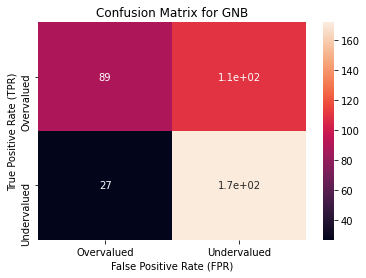

In [61]:
gnb_ros_y_pred = gnb_ros.predict(X_test_ros)
gnb_ros_con_mat = confusion_matrix(y_test_ros, gnb_ros_y_pred)
ax = plt.subplot()
sns.heatmap(gnb_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for GNB')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

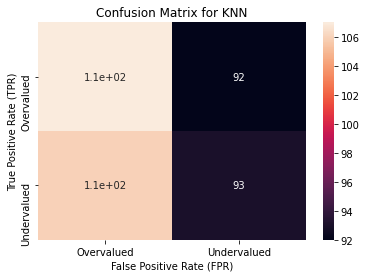

In [62]:
plt.clf() # clear figure
knn_ros_y_pred = knn_ros.predict(X_test_ros)
knn_ros_con_mat = confusion_matrix(y_test_ros, knn_ros_y_pred)
ax = plt.subplot()
sns.heatmap(knn_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for KNN')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

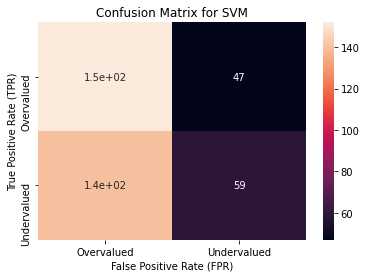

In [63]:
plt.clf() # clear figure
svm_ros_y_pred = svm_ros.predict(X_test_ros)
svm_ros_con_mat = confusion_matrix(y_test_ros, svm_ros_y_pred)
ax = plt.subplot()
sns.heatmap(svm_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

In [64]:
# use Area Under Curve (AUC) to determine which classifier is the best
label_encoder = LabelEncoder()
le_y_test_ros = label_encoder.fit_transform(y_test_ros) # overvalued=0, undervalued=1
y_test_ros = np.asarray(le_y_test_ros).astype('float32')

le_gnb_y_pred = label_encoder.fit_transform(gnb_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_gnb = np.asarray(le_gnb_y_pred).astype('float32')
roc_auc_score_gnb = roc_auc_score(y_test_ros, y_pred_ros_gnb)

le_knn_y_pred = label_encoder.fit_transform(knn_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_knn = np.asarray(le_knn_y_pred).astype('float32')
roc_auc_score_knn = roc_auc_score(y_test_ros, y_pred_ros_knn)

le_svm_y_pred = label_encoder.fit_transform(svm_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_svm = np.asarray(le_svm_y_pred).astype('float32')
roc_auc_score_svm = roc_auc_score(y_test_ros, y_pred_ros_svm)

print('roc_auc_score of GNB =', roc_auc_score_gnb)
print('roc_auc_score of KNN =', roc_auc_score_knn)
print('roc_auc_score of SVM =', roc_auc_score_svm)


roc_auc_score of GNB = 0.6557788944723618
roc_auc_score of KNN = 0.5025125628140704
roc_auc_score of SVM = 0.5301507537688442


In [65]:
print('df_train_drop_na', df_train_drop_na['target'].shape)
print('p_df_train', sdd_df_train.shape)
print('df_test_drop_na', df_test_drop_na['target'].shape)
print('p_df_test', sdd_df_test.shape)

df_train_drop_na (78,)
p_df_train (78, 8)
df_test_drop_na (271,)
p_df_test (271, 8)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_test_ros, y_test_ros,test_size=0.1, random_state=42, shuffle=True)

print('X_train.shape:', X_train.shape)
print('X_test.shape', X_test.shape)

label_encoder = LabelEncoder()
le_y_train = label_encoder.fit_transform(y_train) # overvalued=0, undervalued=1
y_train = np.asarray(le_y_train).astype('float32')
le_y_test = label_encoder.fit_transform(y_test)
y_test = np.asarray(le_y_test).astype('float32')

# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_train = to_categorical(np.asarray(y_train).astype('float32'))

# y_test = label_encoder.fit_transform(y_test)
# y_test = to_categorical(np.asarray(y_test).astype('float32'))

model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(8,)))
model.add(Dense(200, activation='relu', input_dim=8))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Flatten())
model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
# opt = SGD(lr=0.01, momentum=0.9)
opt = 'rmsprop'
# opt = Adam(lr=0.001)
# opt = 'adadelta'
# opt = 'adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=60, epochs=10, verbose=1, validation_split=0.25)
history = model.fit(X_train, y_train, batch_size=8, epochs=4, verbose=1, validation_data=(X_test, y_test))
model.summary()


results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)

print('\n')
print('results_train: ', results_train)
print('results_test:', results_test)


# X_train

X_train.shape: (358, 8)
X_test.shape (40, 8)
Epoch 1/4
45/45 [==============================] - 3s 23ms/step - loss: 0.6995 - accuracy: 0.5816 - val_loss: 0.7274 - val_accuracy: 0.5000
Epoch 2/4
45/45 [==============================] - 0s 10ms/step - loss: 0.6369 - accuracy: 0.6222 - val_loss: 0.6749 - val_accuracy: 0.6500
Epoch 3/4
45/45 [==============================] - 0s 9ms/step - loss: 0.5755 - accuracy: 0.7332 - val_loss: 0.6336 - val_accuracy: 0.6750
Epoch 4/4
45/45 [==============================] - 0s 10ms/step - loss: 0.5705 - accuracy: 0.7472 - val_loss: 0.6329 - val_accuracy: 0.6500
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_45 (Dense)             (None, 200)               40200     
___________________________________________

In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

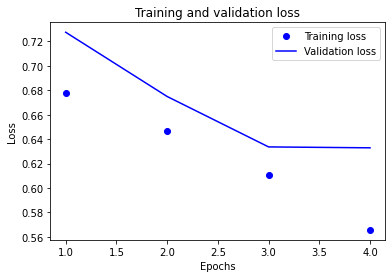

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

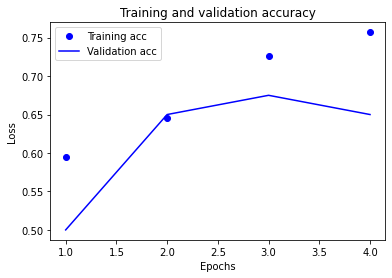

In [69]:
plt.clf()
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# define neural network model
def baseline_model():
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=8))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = 'rmsprop'
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [71]:
# evaluate model with k-fold cross validation
estimator = KerasClassifier(build_fn=baseline_model, epochs=4, batch_size=20, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_test_drop_na['target'])
# y_train = to_categorical(df_test_drop_na['target'])
# print(y_train)
r = cross_val_score(estimator, X_test_ros, y_test_ros, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (r.mean()*100, r.std()*100))

Baseline: 71.87% (8.10%)


In [72]:
# make prediction using model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.55) # increase the threshold for overvalued because I want to get more True positive for Undervalued so that I can buy them and sell for profit later
# y_pred

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

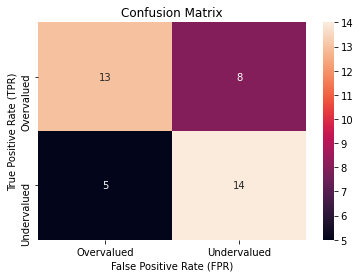

In [73]:
con_mat = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

In [74]:
# export model for backend API
model_dir = os.path.join(curr_dir, 'trained_ML_model')

try:
    os.makedirs(model_dir)
except FileExistsError:
    pass

model_name = 'stock_prediction_model_svm.pkl'
# model_name = 'stock_prediction_model_knn.pkl'
# model_name = 'stock_prediction_model_ANN.pkl'


model_path = os.path.join(curr_dir, 'trained_ML_model', model_name)

joblib.dump(svm_ros, model_path)
# joblib.dump(knn_ros, model_path)
# joblib.dump(model, model_path)



['/home/thomas/Desktop/capstone_project/backend/stocks/webscraper/trained_ML_model/stock_prediction_model_svm.pkl']